# Import Modules
You may need to install some of them.
But if you activate the environment inside this `examples` folder, all dependencies should be included.

In [1]:
using Pkg
Pkg.instantiate()

## 3D Example

In [2]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, OffsetArrays

FFTW.set_num_threads(4)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

┌ Info: DeconvOptim.jl: CUDA.jl is loaded, so include GPU functionality
└ @ DeconvOptim /home/fxw/.julia/packages/DeconvOptim/mveIX/src/requires.jl:6
┌ Warning: Replacing module `ImageCore`
└ @ Base loading.jl:1036


h_view (generic function with 1 method)

In [3]:
# load test images
img = Float32.(testimage("simple_3d_ball"))

psf = permutedims(ifftshift(OffsetArrays.no_offset_view(Float32.(testimage("simple_3d_psf")))), (3,1,2))
psf_c = CuArray(psf)

img_b = conv(img, psf, [1,2,3])
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n);

┌ Warning: Replacing module `ImageCore`
└ @ Base loading.jl:1036


In [4]:
reg = TV(mode="forward", num_dims=3)

#160 (generic function with 1 method)

In [12]:
@time resG, optim_res = deconvolution(img_n, psf, padding=0.01, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

  0.537033 seconds (37.41 k allocations: 383.904 MiB, 1.80% gc time)


([0.00012671082 0.00029431473 … 0.00030053046 0.00013208551; 4.0987587f-5 0.00033449443 … 0.00033617337 4.737917f-5; … ; 4.0480983f-5 0.00033495665 … 0.0003334541 4.7522488f-5; 0.0001237056 0.000295984 … 0.00030174016 0.00013284705;;; 0.00029436898 8.339931f-5 … 8.407723f-5 0.00029890492; 0.00033448447 3.8971408f-5 … 3.8947423f-5 0.00034336536; … ; 0.00033495764 3.833878f-5 … 3.9274753f-5 0.0003433388; 0.00029603738 8.282181f-5 … 8.357156f-5 0.00029926785;;; 0.00027195984 2.0081428f-7 … 1.237464f-7 0.0002703428; 0.00020410237 1.4251748f-6 … 1.5024924f-6 0.00020802644; … ; 0.00020345999 1.5339524f-6 … 1.4701264f-6 0.00020857196; 0.0002718016 1.7281434f-7 … 1.2927956f-7 0.00027132328;;; … ;;; 0.0002751577 1.6564415f-7 … 1.6660144f-7 0.00027384565; 0.00021121383 1.4080651f-6 … 1.2386619f-6 0.00020966574; … ; 0.00022075421 1.0819895f-6 … 1.2759429f-6 0.00021491422; 0.00028425307 4.4040567f-7 … 2.581326f-7 0.00027663025;;; 0.00030017318 8.446014f-5 … 8.287391f-5 0.00030152337; 0.00033585174

In [6]:
reg_c = TV_cuda(num_dims=3)

#25 (generic function with 1 method)

In [13]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, padding = 0.01, loss=Poisson(), regularizer=reg_c, λ=0.005, iterations=20)

  0.098249 seconds (115.31 k CPU allocations: 9.139 MiB, 9.17% gc time) (1.76 k GPU allocations: 1.138 GiB, 14.41% memmgmt time)


([0.00012672764 0.0002937549 … 0.00029996983 0.00013214552; 4.1086325f-5 0.0003339746 … 0.00033565535 4.7484187f-5; … ; 4.0575567f-5 0.0003344322 … 0.00033294514 4.7628826f-5; 0.00012374655 0.00029542283 … 0.0003011745 0.00013290724;;; 0.0002938089 8.340971f-5 … 8.408828f-5 0.00029834578; 0.00033396386 3.9000108f-5 … 3.897874f-5 0.00034285247; … ; 0.0003344333 3.8367805f-5 … 3.9305192f-5 0.00034282837; 0.00029547574 8.283344f-5 … 8.35834f-5 0.00029870836;;; 0.00027176904 2.0346806f-7 … 1.2591622f-7 0.00027014973; 0.0002040167 1.4188773f-6 … 1.4961162f-6 0.00020793073; … ; 0.00020337499 1.5274318f-6 … 1.4638534f-6 0.0002084754; 0.00027161257 1.7525777f-7 … 1.3150628f-7 0.00027112776;;; … ;;; 0.00027495567 1.6813824f-7 … 1.690906f-7 0.00027365182; 0.00021111334 1.4016274f-6 … 1.2328011f-6 0.00020957585; … ; 0.00022065018 1.0758595f-6 … 1.2698249f-6 0.00021481571; 0.0002840395 4.4477216f-7 … 2.612373f-7 0.00027642897;;; 0.00029961177 8.4471365f-5 … 8.288273f-5 0.00030095584; 0.00033533355

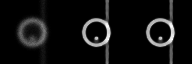

In [14]:
h_view(img_n[32, :, :], resG[32, :, :], Array(resG_c)[32, :, :])

In [15]:
.≈(resG .+ 1, Array(1 .+ resG_c), rtol=1e-2) |> all

true